# ADAGE: Pan-cancer gene expression

**Gregory Way 2017**

This script trains a denoising autoencoder for cancer gene expression data using Keras. It modifies the framework presented by the ADAGE (Analysis using denoising autoencoders of gene expression) model published by [Tan _et al_ 2015](https://doi.org/10.1128/mSystems.00025-15).

An ADAGE model learns a non-linear, reduced dimensional representation of gene expression data by bottlenecking raw features into a smaller set. The model is then trained by minimizing the information lost between input and reconstructed input.

The specific model trained in this notebook consists of gene expression input (5000 most variably expressed genes by median absolute deviation) compressed down into one length 100 vector. The hidden layer is then decoded back to the original 5000 dimensions. The encoding (compression) layer has a `relu` activation and the decoding layer has a `sigmoid` activation. The weights of each layer are glorot uniform initialized. We include an l1 regularization term (see [`keras.regularizers.l1`](https://keras.io/regularizers/) for more details) to induce sparsity in the model, as well as a term controlling the probability of input feature dropout. This is only active during training and is the denoising aspect of the model. See [`keras.layers.noise.Dropout`](https://keras.io/layers/core/) for more details.

We train the autoencoder with the Adadelta optimizer and MSE reconstruction loss.

The pan-cancer ADAGE model is similar to tybalt, but does not constrain the features to match a Gaussian distribution. It is an active research question if the VAE learned features provide any additional benefits over ADAGE features. The VAE is a generative model and therefore permits easy generation of fake data. Additionally, we hypothesize that the VAE learns a manifold that can be interpolated to extract meaningful biological knowledge.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.layers import Input, Dense, Dropout, Activation
from keras.layers.noise import GaussianDropout
from keras.models import Model
from keras.regularizers import l1
from keras import optimizers
import keras

Using TensorFlow backend.


In [2]:
print(keras.__version__)

2.0.6


In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [4]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})

In [5]:
# Load RNAseq data
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

(10459, 5000)


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [6]:
np.random.seed(123)

In [7]:
# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

## Parameter Sweep Results

We previously performed a parameter sweep search over a grid of potential hyperparameter values. Based on this sweep, we determined that the optimal ADAGE parameters are:

| Parameter | Optimal Setting |
| :-------: | :-------------: |
| Learning Rate | 1.1 |
| Sparsity | 0 |
| Noise | 0.05 |
| Epochs | 100 |
| Batch Size | 50 |

In [8]:
num_features = rnaseq_df.shape[1]
encoding_dim = 100
sparsity = 0
noise = 0.05
epochs = 100
batch_size = 50
learning_rate = 1.1

In [9]:
# Build the Keras graph
input_rnaseq = Input(shape=(num_features, ))
encoded_rnaseq = Dropout(noise)(input_rnaseq)
encoded_rnaseq_2 = Dense(encoding_dim,
                         activity_regularizer=l1(sparsity))(encoded_rnaseq)
activation = Activation('relu')(encoded_rnaseq_2)
decoded_rnaseq = Dense(num_features, activation='sigmoid')(activation)

autoencoder = Model(input_rnaseq, decoded_rnaseq)

In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               500100    
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5000)              505000    
Total params: 1,005,100
Trainable params: 1,005,100
Non-trainable params: 0
_________________________________________________________________


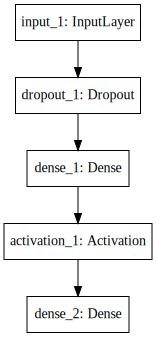

In [11]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('figures', 'adage_architecture.png')
plot_model(autoencoder, to_file=output_model_file)

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [12]:
# Separate out the encoder and decoder model
encoder = Model(input_rnaseq, encoded_rnaseq_2)

encoded_input = Input(shape=(encoding_dim, ))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [13]:
# Compile the autoencoder to prepare for training
adadelta = optimizers.Adadelta(lr=learning_rate)
autoencoder.compile(optimizer=adadelta, loss='mse')

In [14]:
%%time
hist = autoencoder.fit(np.array(rnaseq_train_df), np.array(rnaseq_train_df),
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)))

Train on 9413 samples, validate on 1046 samples
Epoch 1/100
9413/9413 [==============================] - 6s - loss: 0.0570 - val_loss: 0.0365
Epoch 2/100
9413/9413 [==============================] - 7s - loss: 0.0358 - val_loss: 0.0359
Epoch 3/100
9413/9413 [==============================] - 7s - loss: 0.0355 - val_loss: 0.0357
Epoch 4/100
9413/9413 [==============================] - 7s - loss: 0.0352 - val_loss: 0.0353
Epoch 5/100
9413/9413 [==============================] - 5s - loss: 0.0348 - val_loss: 0.0348
Epoch 6/100
9413/9413 [==============================] - 6s - loss: 0.0342 - val_loss: 0.0341
Epoch 7/100
9413/9413 [==============================] - 6s - loss: 0.0334 - val_loss: 0.0331
Epoch 8/100
9413/9413 [==============================] - 7s - loss: 0.0323 - val_loss: 0.0321
Epoch 9/100
9413/9413 [==============================] - 5s - loss: 0.0313 - val_loss: 0.0311
Epoch 10/100
9413/9413 [==============================] - 6s - loss: 0.0305 - val_loss: 0.0303
Epoch 11/10

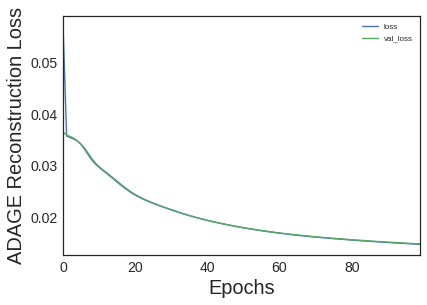

In [15]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'adage_training.png')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('ADAGE Reconstruction Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

### Save Model Outputs

In [16]:
# Encode rnaseq into the hidden/latent representation - and save output
encoded_samples = encoder.predict(np.array(rnaseq_df))
encoded_rnaseq_df = pd.DataFrame(encoded_samples, index=rnaseq_df.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1
encoded_file = os.path.join('data', 'encoded_adage_features.tsv')
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')

In [17]:
# Output weight matrix of gene contributions per node
weight_matrix = pd.DataFrame(autoencoder.get_weights()[0], index=rnaseq_df.columns)
weight_file = os.path.join('data', 'adage_gene_weights.tsv')
weight_matrix.to_csv(weight_file, sep='\t')

## Observe reconstruction

In [18]:
# Reconstruct input RNAseq
decoded_samples = decoder.predict(encoded_samples)

reconstructed_df = pd.DataFrame(decoded_samples, index=rnaseq_df.index,
                                columns=rnaseq_df.columns)

In [19]:
reconstruction_fidelity = rnaseq_df - reconstructed_df

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,-0.001979,0.239137
GSTT1,0.023439,0.232452
GSTM1,0.005325,0.219904
EIF1AY,-0.048682,0.209454
DDX3Y,-0.034103,0.207382


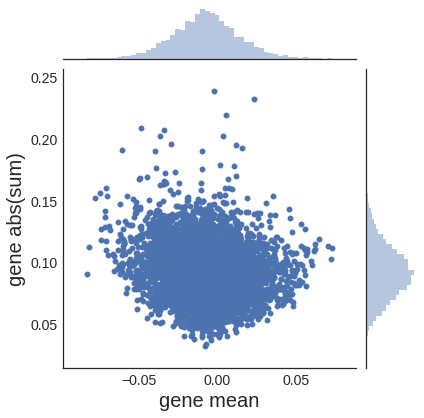

In [20]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
reconstruct_fig_file = os.path.join('figures', 'adage_gene_reconstruction.png')
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary, stat_func=None);
g.savefig(reconstruct_fig_file)

In [21]:
# What are the most and least activated nodes
sum_node_activity = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)

# Top 5 most active nodes
print(sum_node_activity.head(5))

# Bottom 10 least active nodes
sum_node_activity.tail(5)

sample_id
32    116167.968750
16    111224.648438
80     97696.039062
66     96676.765625
40     95195.609375
dtype: float32


sample_id
25   -11347.205078
24   -12289.718750
87   -12757.310547
41   -13314.519531
49   -16946.773438
dtype: float32

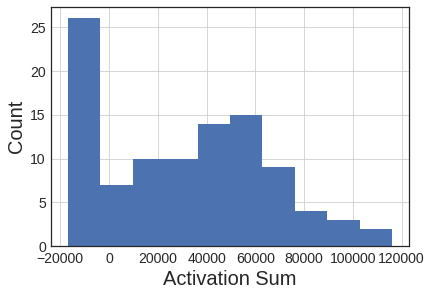

In [22]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');

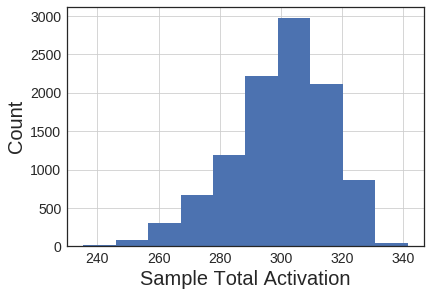

In [23]:
# Histogram of sample activity for all 10,000 samples
encoded_rnaseq_df.sum(axis=1).hist()
plt.xlabel('Sample Total Activation')
plt.ylabel('Count');

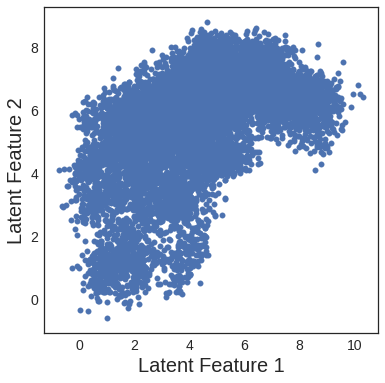

In [24]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 1], encoded_rnaseq_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2');